In [1]:
import pandas as pd

### 1. Загружаем исходный датасет
#### Для того, чтобы минимизировать memory usage приведем в соответствие тип данных в столбцах

In [2]:
df_train = pd.read_csv('train.csv', sep=',', index_col=0,
                       dtype = {'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 
                                'content_type_id': 'int8', 'task_container_id': 'int16', 'user_answer': 'int8', 
                                'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                                'prior_question_had_explanation': 'boolean'
                               }
                      )

In [3]:
df_train.head(10)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False
5,157063,115,156,0,5,2,1,5000.0,False
6,176092,115,51,0,6,0,1,17000.0,False
7,194190,115,50,0,7,3,1,17000.0,False
8,212463,115,7896,0,8,2,1,16000.0,False


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


#### Найдем количество уникальных значений в колонках

In [10]:
unique_list = []
for col in df_train.columns:
    item = (col, df_train[col].nunique(), df_train[col].dtype)
    unique_list.append(item)
unique_counts = pd.DataFrame(unique_list,
                             columns=['Column_Name', 'Num_Unique', 'Type']
                            ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts)

,Column_Name,Num_Unique,Type
0,content_type_id,2,int8
1,prior_question_had_explanation,2,boolean
2,answered_correctly,3,int8
3,user_answer,5,int8
4,prior_question_elapsed_time,3258,float32
5,task_container_id,10000,int16
6,content_id,13782,int16
7,user_id,393656,int32
8,timestamp,72821015,int64


#### Исследуем соотношение правильных и неправильных ответов (без лекций)

In [12]:
df_train[df_train['answered_correctly'] != -1]['answered_correctly'].value_counts(normalize=True) 
df_train[df_train['answered_correctly'] != -1]['answered_correctly'].value_counts()[1] 
df_train[df_train['answered_correctly'] != -1]['answered_correctly'].value_counts()[0]
df_train[df_train['answered_correctly'] != -1]['answered_correctly'].mean()

0.6572355454194717

- 66% составляют правильные ответы (65 244 627), 34% - неправильные (34 026 673)
- 0.657 - средний балл студента

#### Получим дополнительные характеристики датасета

In [14]:
df_train[df_train['content_type_id'] == 0].shape[0] / df_train['user_id'].nunique()
df_train[df_train['answered_correctly'] != -1]['answered_correctly'].sum() / df_train['user_id'].nunique()
df_train[df_train['content_type_id'] == 1].shape[0] / df_train['user_id'].nunique()
df_train['prior_question_had_explanation'].sum() / df_train['user_id'].nunique()
df_train['prior_question_elapsed_time'].mean()

13005.0810546875

- Cреднее число отвеченных вопросов: 252.17
- Среднее кол-во правильных ответов: 165.74
- Среднее число просмотренных лекций: 4.97
- Среднее число виденных объяснений: 227.82
- Среднее время, затрачиваемое на вопрос: 13005

#### Проанализируем меняется ли % правильных ответов в зависиомсти от: времени с начала сессии; среднего времеми ответа студента на вопросы; видел ли студент правильный ответ на предыдущее задание

In [15]:
pd.DataFrame({'timestamp': df_train[df_train['answered_correctly'] != -1]['timestamp'].groupby(df_train['answered_correctly']).mean(),
              'prior_questions_time': df_train[df_train['answered_correctly'] != -1]['prior_question_elapsed_time'].groupby(df_train['answered_correctly']).mean(),
              'had_explanation': df_train[df_train['answered_correctly'] != -1]['prior_question_had_explanation'].groupby(df_train['answered_correctly']).sum()
             }
            )

,timestamp,prior_questions_time,had_explanation
answered_correctly,,,
0,7.235711e+09,25641.992188,29310272
1,7.945270e+09,25309.976562,60375288


Можно сделать следующие выводы:
- чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты
- студенты, тратящие меньше времени на решение, чаще отвечают правильно
- если студент видел объяснение предыдущий задачи, вероятность правильного ответа удваивается

#### Аналитика по студентам

In [18]:
students_list = list(df_train['user_id'].unique())
users_q = len(students_list)

Всего 393656 уникальных студентов

Сделаем выборку из всего списка студентов 300 уникальных и проанализируем их активность.

In [19]:
students_list = students_list[:300]

Посчитаем время на платформе для каждого студента

In [20]:
time = []
for student in students_list:
    t = df_train[df_train['user_id'] == student]['timestamp'].max()
    time.append(t)

Количество отвеченных вопросов

In [21]:
ques_quant = []
for student in students_list:
    q = df_train[(df_train['user_id'] == student) & (df_train['content_type_id'] == 0)]['content_type_id'].count()
    ques_quant.append(q)

Cредний балл студента:

In [23]:
av_grade = []
for student in students_list:
    g = df_train[(df_train['user_id'] == student) & (df_train['answered_correctly'] != -1)]['answered_correctly'].mean()
    av_grade.append(g)

Количество просмотренных лекций

In [24]:
lec_watched = []
for student in students_list:
    l = df_train[df_train['user_id'] == student]['content_type_id'].sum()
    lec_watched.append(l)

Количество введенных объяснений на предыдущие вопросы

In [25]:
expl_watched = []
for student in students_list:
    e = df_train[df_train['user_id'] == student]['prior_question_had_explanation'].sum()
    expl_watched.append(e)

Время, в среднем потраченное студентом на каждый вопрос:

In [26]:
ques_time = []
for student in students_list:
    qt = df_train[(df_train['user_id'] == student)]['prior_question_elapsed_time'].mean()
    ques_time.append(qt)

Запишем данные по 300 отобранным студентам в единую таблицу:

In [27]:
students = pd.DataFrame({'user_id': students_list,
                        'time': time,
                        'ques_quant': ques_quant,
                        'av_grade': av_grade,
                        'lec_watched': lec_watched,
                        'expl_watched': expl_watched,
                         'ques_time': ques_time
                       }
                      )
students = students.astype({'user_id': 'int32',
                            'time': 'int64',
                            'ques_quant': 'int16', 
                            'av_grade': 'float32',
                            'lec_watched': 'int16',
                            'expl_watched': 'int16',
                            'ques_time': 'float32'
                           })

In [28]:
students.head(10)

,user_id,time,ques_quant,av_grade,lec_watched,expl_watched,ques_time
0,115,668090043,46,0.695652,0,6,19933.310547
1,124,571323,30,0.233333,0,0,18793.000000
2,2746,835457,19,0.578947,1,11,18055.554688
3,5382,2101551456,125,0.672000,3,113,36048.386719
4,8623,862338736,109,0.642202,3,96,26107.408203
5,8701,1571291,17,0.588235,0,9,21375.000000
6,12741,4465486358,265,0.573585,6,250,39834.914062
7,13134,18122046414,1243,0.706356,7,1233,21621.433594
8,24418,14243735782,6283,0.690275,181,6251,21404.572266
9,24600,1550831,50,0.340000,0,19,22719.347656


In [29]:
students.describe()

,user_id,time,ques_quant,av_grade,lec_watched,expl_watched,ques_time
count,3.000000e+02,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000
mean,8.864180e+05,5.051797e+09,271.770000,0.540567,4.646667,249.456667,23844.164062
std,5.359876e+05,9.986648e+09,794.462282,0.170348,15.970347,790.950464,7774.491699
min,1.150000e+02,5.737300e+04,7.000000,0.000000,0.000000,0.000000,1344.862061
25%,3.853472e+05,1.394032e+06,30.000000,0.426339,0.000000,9.000000,19280.315918
50%,9.056425e+05,4.896570e+08,47.000000,0.578046,0.000000,23.000000,22929.346680
75%,1.349270e+06,4.637351e+09,150.750000,0.663947,2.000000,127.000000,26735.916992
max,1.822782e+06,5.949531e+10,7476.000000,0.923077,181.000000,7465.000000,60351.351562


#### Гистограма распределения средних оценок среди студентов

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

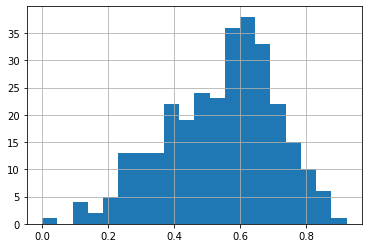

In [30]:
students['av_grade'].hist(bins=20)

### Исследуем questions.csv

In [31]:
questions = pd.read_csv('questions.csv', sep=',',
                        dtype = {'question_id': 'int16', 'bundle_id': 'int16', 'correct_answer': 'int8',
                                 'part': 'int8', 'tags': 'object'
                               })
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


In [32]:
unique_list_q = []
for col in questions.columns:
    item = (col, questions[col].nunique(), questions[col].dtype)
    unique_list_q.append(item)
unique_counts_q = pd.DataFrame(unique_list_q,
                               columns=['Column_Name', 'Num_Unique', 'Type']
                              ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_q)

,Column_Name,Num_Unique,Type
0,correct_answer,4,int8
1,part,7,int8
2,tags,1519,object
3,bundle_id,9765,int16
4,question_id,13523,int16


In [33]:
questions['question_id'].groupby(questions['bundle_id']).count().max()
questions['part'].value_counts(normalize=True)
questions['tags'].describe()

count     13522
unique     1519
top           8
freq        738
Name: tags, dtype: object

- Часть вопросов объединены по bundle_id в блоки до 5 вопросов, хотя большинство представлены по одиночке
- Задачи разделены по темам на 7 разделов, больше всего посвящено 5му разделу, 2, 3 и 4

In [34]:
q_tags = set()
for tag in questions['tags']:
    try:
        for t in tag.split():
                q_tags.add(int(t))
    except:
        q_tags.add(int(t))
len(q_tags)

188

Можно провести доп исследование вопросов, используя кластеризацию по 188 доп.признакам 'tags'

In [35]:
tmp_df = df_train.loc[(df_train.content_type_id == 0), ['content_id', 'answered_correctly']]

In [36]:
q_list = list(tmp_df['content_id'].unique())
len(q_list)

13523

Всего 13523 уникальных вопросов. Мы берем этот список из файла Train, чтобы иметь правильный порядок данных

Столбцы :
- q_quant - общее количество ответов для каждого id
- correct_quant - количество правильных ответов для каждого id

In [38]:
q_quant = []
correct_quant = []
for q in q_list:
    tmp = tmp_df[tmp_df['content_id'] == q]['answered_correctly'].count()
    tmp1 = tmp_df[tmp_df['content_id'] == q]['answered_correctly'].sum()
    q_quant.append(tmp)
    correct_quant.append(tmp1)

Запишем полученные данные в единую таблицу

In [39]:
q_ex = pd.DataFrame({'question_id': q_list,
                        'q_quant': q_quant,
                        'correct_quant': correct_quant
                       }
                      )
q_ex = q_ex.astype({'question_id': 'int16', 'q_quant': 'int32', 'correct_quant': 'int32'})

In [40]:
questions = questions.drop('correct_answer', axis=1)
questions = pd.merge(questions, q_ex, how='inner')
questions['correct_percent'] = questions['correct_quant'] / questions['q_quant']
questions.describe()

,question_id,bundle_id,part,q_quant,correct_quant,correct_percent
count,13523.00000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,4.264956,7340.922872,4824.715448,0.709460
std,3903.89818,3903.857783,1.652553,11455.927774,6419.482619,0.164486
min,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3380.50000,3379.500000,3.000000,1765.500000,1274.000000,0.609345
50%,6761.00000,6761.000000,5.000000,4732.000000,3236.000000,0.734215
75%,10141.50000,10140.000000,5.000000,8556.000000,5877.500000,0.835116
max,13522.00000,13522.000000,7.000000,213605.000000,149422.000000,1.000000


In [41]:
questions

,question_id,bundle_id,part,tags,q_quant,correct_quant,correct_percent
0,0,0,1,51 131 162 38,6903,6266,0.907721
1,1,1,1,131 36 81,7398,6589,0.890646
2,2,2,1,131 101 162 92,44905,24890,0.554281
3,3,3,1,131 149 162 29,22973,17906,0.779437
4,4,4,1,131 5 162 38,31736,19461,0.613215
...,...,...,...,...,...,...,...
13518,13518,13518,5,14,868,683,0.786866
13519,13519,13519,5,8,924,528,0.571429
13520,13520,13520,5,73,861,579,0.672474
13521,13521,13521,5,125,870,703,0.808046


- По мере продвижения по разделам, видимо, сложность курса возрастает. 
- 5й раздел содержит максимальное число леций и заданий, однако средняя успеваемость студентов для него самая низкая.

### Исследуем lectures.csv

In [42]:
lectures = pd.read_csv('lectures.csv', sep=',',
                      dtype = {'lecture_id': 'int16', 'tag': 'int16', 
                               'part': 'int8', 'type_of': 'object'})
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


In [43]:
unique_list_lec = []
for col in lectures.columns:
    item = (col, lectures[col].nunique(), lectures[col].dtype)
    unique_list_lec.append(item)
unique_counts_lec = pd.DataFrame(unique_list_lec,
                                 columns=['Column_Name', 'Num_Unique', 'Type']
                                ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_lec)

,Column_Name,Num_Unique,Type
0,type_of,4,object
1,part,7,int8
2,tag,151,int16
3,lecture_id,418,int16


- Лекции разделены по темам на 7 разделов, больше всего лекций посвящено 5му разделу, затем 6, 2 и 1
- С учетом данных по вопросам, можно прийти к заключению, что 5 раздел - самый насыщенный по материалу,
- 6 и 1 - более теоретические, а 3 и 4 - более прикладные.
- Леции бывают 4 типов: вступление, целеполагание, концептуальное изложение материала и решение задач.
- Большинство лекций посвящены теории, немного меньше - решению задач. Доля остальных несущественна.
- Есть 151 доп.тип лекций, по которым можно провести кластеризацию

In [44]:
lectures['part'].value_counts(normalize=True)
lectures['type_of'].value_counts(normalize=True)
lectures['tag'].value_counts().head()

136    7
27     6
161    6
74     6
134    6
Name: tag, dtype: int64

Найдем количество уникальных значений

In [45]:
l_list = list(df_train[df_train['content_type_id'] == 1]['content_id'].unique())
len(l_list)

415

Посчитаем количество просмотров лекций для каждого id

In [46]:
l_quant = []
for l in l_list:
    tmp_l = df_train[(df_train['content_id'] == l)]['content_id'].count()
    l_quant.append(tmp_l)

In [47]:
l_ex = pd.DataFrame({'lecture_id': l_list,
                        'l_quant': l_quant
                       }
                      )
l_ex = l_ex.astype({'lecture_id': 'int16', 'l_quant': 'int32'})
lectures = pd.merge(lectures, l_ex, how='inner')
display(lectures)

,lecture_id,tag,part,type_of,l_quant
0,89,159,5,concept,24468
1,100,70,1,concept,18284
2,185,45,6,concept,47470
3,192,79,5,solving question,11073
4,317,156,5,solving question,11161
...,...,...,...,...,...
410,32535,8,5,solving question,3666
411,32570,113,3,solving question,2910
412,32604,24,6,concept,4
413,32625,142,2,concept,8031


Общий рейтинг популярности для лекций

In [48]:
lectures.sort_values(by=['l_quant'], ascending=False).head()

,lecture_id,tag,part,type_of,l_quant
124,10688,39,7,concept,133046
5,335,114,2,concept,60616
44,3852,161,4,solving question,57766
2,185,45,6,concept,47470
62,5694,140,2,concept,46255


Рейтинг популярности для лекций, в зависимости от раздела

In [49]:
lectures.groupby('part').sum()['l_quant'].sort_values(ascending=False)

part
5    1231941
2     565635
6     493644
1     354329
7     256938
4     191726
3     153522
Name: l_quant, dtype: int32

Рейтинг популярности для лекций, в зависимости от тега лекции

In [50]:
lectures.groupby('tag').sum()['l_quant'].sort_values(ascending=False).head()

tag
39     133046
161     91792
62      80640
27      79111
114     69673
Name: l_quant, dtype: int32

- Часть вопросов объединены по bundle_id в блоки до 5 вопросов, хотя большинство представлены по одиночке
- Лекции бывают 4 типов: вступление, целеполагание, концептуальное изложение материала и решение задач.
- Задачи и лекции разделены по темам на 7 разделов
- Наибольшее число просмотров имеет лекция из 5го раздела.